<a href="https://colab.research.google.com/github/PPKoller/2x2-FNAL/blob/master/googlecolab/notebooks/eBay_cars_model_FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Mount google drive:

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Load CSV file from google drive into pandas dataframe: (drop index column)

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/gdrive/My Drive/AMAG/Data/eBay_cars/cars_use_case_clean.csv', index_col=0).reset_index().drop(columns='index')
df

,seller,offerType,price,abtest,vehicleType,gearbox,powerPS,kilometer,fuelType,notRepairedDamage,dateOfRegistration,age_years,brand,model
0,privat,Angebot,1500,test,kleinwagen,manuell,75,150000,benzin,nein,992563200,14.756597,Volkswagen,golf
1,privat,Angebot,3600,test,kleinwagen,manuell,69,90000,diesel,nein,1216080000,7.727547,Skoda,fabia
2,privat,Angebot,650,test,limousine,manuell,102,150000,benzin,ja,813715200,20.479007,BMW,316i
3,privat,Angebot,2200,test,cabrio,manuell,109,150000,benzin,nein,1092528000,11.640932,Peugeot,206
4,privat,Angebot,2000,control,limousine,manuell,105,150000,benzin,nein,1103068800,11.308783,Mazda,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201442,privat,Angebot,4400,control,limousine,manuell,105,150000,diesel,nein,1216080000,7.728170,Seat,leon
201443,privat,Angebot,1490,control,kleinwagen,manuell,50,150000,benzin,nein,905817600,17.559485,Volkswagen,lupo
201444,privat,Angebot,7900,test,limousine,manuell,140,150000,diesel,nein,1279152000,5.718834,Volkswagen,golf
201445,privat,Angebot,3999,test,kombi,manuell,3,150000,diesel,nein,1116115200,10.896503,BMW,320


Define scalers and encoders, apply encoder:

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler

scale_cat = df.select_dtypes(include=['int64', 'float64']).drop(columns='price').columns.tolist()
enc_cat = df.select_dtypes(include=['object']).columns.tolist()

X_scaler = RobustScaler()
y_scaler = RobustScaler()

encoder = OneHotEncoder()

X_scaler.fit(df[scale_cat])
y_scaler.fit(df['price'].array.reshape(-1,1))

encoder.fit(df[enc_cat])
df = df.join(pd.DataFrame(encoder.transform(df[enc_cat]).toarray())).drop(columns=enc_cat)

Split dataset into training and test samples (80% and 20%), re-index:


In [4]:
from sklearn.model_selection import train_test_split

y = df['price']
X = df.drop(columns='price')

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

X_train = X_train.reset_index().drop(columns='index')
X_test = X_test.reset_index().drop(columns='index')

y_train = y_train.reset_index().drop(columns='index')
y_test = y_test.reset_index().drop(columns='index')

Apply scalers:

In [5]:
X_test_orig = X_test.copy()

X_train[scale_cat] = X_scaler.transform(X_train[scale_cat])
X_test[scale_cat] = X_scaler.transform(X_test[scale_cat])

y_train = y_scaler.transform(np.array(y_train).reshape(-1, 1))
y_test = y_scaler.transform(np.array(y_test).reshape(-1, 1))

#X_train = X_train.join(pd.DataFrame(encoder.transform(df[enc_cat]).toarray())).drop(columns=enc_cat)
#X_test = X_test.join(pd.DataFrame(encoder.transform(df[enc_cat]).toarray())).drop(columns=enc_cat)


Train FCNN with 2 layers:

In [6]:
from keras.models import Sequential
from keras.layers import Dense

model=Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

epochs=3
batch_size=50

history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=epochs, batch_size=batch_size, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               94464     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 94,593
Trainable params: 94,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
3224/3224 [==============================] - 18s 5ms/step - loss: 0.0681 - val_loss: 0.0617
Epoch 2/3
3224/3224 [==============================] - 15s 5ms/step - loss: 0.0581 - val_loss: 0.0588
Epoch 3/3
3224/3224 [==============================] - 14s 4ms/step - loss: 0.0557 - val_loss: 0.0574


Calculate predictions and inverse price scaling:

In [7]:
predictions_train=y_scaler.inverse_transform(model.predict(np.array(X_train)))
predictions_test=y_scaler.inverse_transform(model.predict(np.array(X_test)))

y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

Calculate and print error metrics:

In [8]:
from sklearn.metrics import mean_squared_log_error,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

mse=mean_squared_error(np.array(y_train),np.array(predictions_train))
mae=mean_absolute_error(y_train,predictions_train)
mape=mean_absolute_percentage_error(y_train,predictions_train)

print('train:')
print(mse)
print(mae)
print(mape)

mse=mean_squared_error(np.array(y_test),np.array(predictions_test))
mae=mean_absolute_error(y_test,predictions_test)
mape=mean_absolute_percentage_error(y_test,predictions_test)

print('\ntest:')
print(mse)
print(mae)
print(mape)

train:
1837148.7637938177
902.6327032164045
3.0696611262557583

test:
1997008.673861988
923.7889243748207
3.1665830510111723


Calculate goodness of fit:

In [9]:
from sklearn.metrics import r2_score

r2=r2_score(y_test, predictions_test)
print(r2)

0.9011833710807856


Invert one-hot tensors and restore original data frame structure:

In [10]:
one_hot = X_test.drop(columns=scale_cat).columns.tolist()

X_test[scale_cat] = X_scaler.inverse_transform(X_test[scale_cat])
X_test[enc_cat] = encoder.inverse_transform(X_test.drop(columns=scale_cat))

X_test['price'] = y_test
X_test['prediction'] = predictions_test

X_test = X_test.drop(columns=one_hot)
X_test

,powerPS,kilometer,dateOfRegistration,age_years,seller,offerType,abtest,vehicleType,gearbox,fuelType,notRepairedDamage,brand,model,price,prediction
0,122.0,150000.0,8.163936e+08,20.360478,privat,Angebot,test,limousine,manuell,benzin,nein,Mercedes-Benz,c,1599.0,1309.155029
1,90.0,150000.0,6.350400e+08,26.135695,privat,Angebot,test,limousine,automatik,benzin,nein,Volkswagen,golf,990.0,1977.802368
2,116.0,60000.0,1.118794e+09,10.809800,privat,Angebot,test,cabrio,manuell,benzin,nein,Mini,cooper,8650.0,8786.937500
3,86.0,150000.0,9.583488e+08,15.876696,privat,Angebot,test,kleinwagen,manuell,benzin,nein,Lancia,y,650.0,1277.047119
4,163.0,150000.0,1.179187e+09,8.896572,privat,Angebot,test,limousine,manuell,diesel,nein,BMW,120d,7200.0,8566.041016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40285,105.0,150000.0,1.047686e+09,13.062472,privat,Angebot,control,limousine,manuell,benzin,nein,Volkswagen,golf,3200.0,3430.103760
40286,150.0,150000.0,8.689248e+08,18.727483,privat,Angebot,control,cabrio,automatik,benzin,nein,BMW,320i,1999.0,3945.857910
40287,67.0,70000.0,1.250294e+09,6.646071,privat,Angebot,control,kleinwagen,manuell,benzin,nein,Hyundai,i10,3600.0,3824.494385
40288,150.0,150000.0,1.029370e+09,13.630020,privat,Angebot,test,kombi,manuell,diesel,nein,BMW,320d,4999.0,3245.940918


Plots:

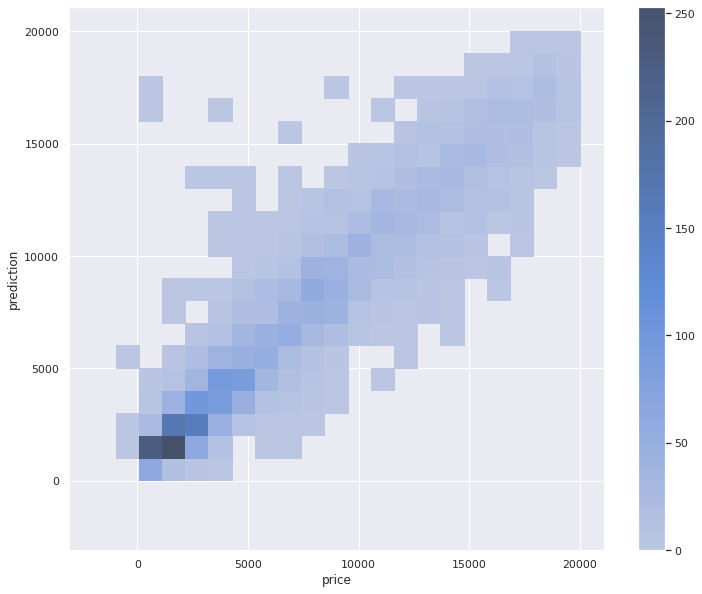

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,10)})
sns.histplot(data=X_test[X_test['brand']=='Audi'], x='price', y='prediction', cbar=True, binrange=(-2000,20000))